# EDA
Exploratory Data Analysis is typically undergone before developing machine learning algorithms. Its important to understand the data before using it in machine learning algorithms, which often make assumptions about the data.

**This notebook achieves the following:**
* Autocorrelation of time-lags (kevin)
* determine stationarity
    * Dickey-fuller test (kevin)
    * Time series decomposition into: trend, seasonal, residual, using the appropiate model (additive or multiplicative) (kevin)
    * heteroskedasticity
* Cointegration between exogenous variables and target (natalie)
* Cross correlation between target and exogenous variables (Muhammed)
* constant time series (kevin)
* ACF/PACF (Natalie)
* ANOVA (Muhammed)

## Imports:

In [5]:
import pandas as pd
from pathlib import Path
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf,ccf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown

## Data

In [2]:
cwd=Path.cwd()
data= pd.read_csv(cwd.parent / 'Data' /'Train'/'train1990s.csv',parse_dates=[0],date_format='%m%Y',index_col=0)
display(data)

,fred_PCEPI,fred_AAAFFM,fred_AAAFFM_PC1,fred_AHETPI,fred_AHETPI_LOG,fred_APU000072610_PCA,fred_APU000074714,fred_APU000074714_CCA,fred_APU000074714_CCH,fred_APU000074714_CH1,...,CMO-Historical-Data-Monthly_Food,CMO-Historical-Data-Monthly_Oils_and_meals,CMO-Historical-Data-Monthly_Grains,CMO-Historical-Data-Monthly_Other_foods,CMO-Historical-Data-Monthly_Raw_materials,CMO-Historical-Data-Monthly_Other_raw_materials,CMO-Historical-Data-Monthly_Fertilizers,CMO-Historical-Data-Monthly_Metals_minerals,CMO-Historical-Data-Monthly_Base metals,CMO-Historical-Data-Monthly_Precious_metals
observation_date,,,,,,,,,,,,,,,,,,,,,
01/1990,58.553,0.76,52.00000,10.02,2.30458,0.00000,1.042,73.61358,6.13447,0.124,...,56.551650,45.351208,60.992920,67.266898,58.901182,50.618837,32.099633,41.358420,45.793110,31.991723
02/1990,58.811,0.98,250.00000,10.07,2.30956,0.00000,1.037,-5.77202,-0.48100,0.111,...,56.076261,44.285143,61.736902,66.464893,59.871703,51.436603,32.491941,40.591515,44.847931,32.495352
03/1990,59.033,1.09,-2280.00000,10.11,2.31353,0.00000,1.023,-16.31093,-1.35924,0.083,...,55.868281,44.290949,61.282788,66.198443,59.207260,51.607571,33.103550,44.825494,50.066137,30.748186
04/1990,59.157,1.20,-2500.00000,10.12,2.31451,15.86333,1.044,24.38400,2.03200,-0.021,...,56.391158,43.846209,62.755064,67.134967,58.945811,52.626887,33.730111,44.470335,49.628419,29.503814
05/1990,59.290,1.29,-637.50000,10.16,2.31846,0.00000,1.061,19.38284,1.61524,-0.058,...,56.064222,45.067305,61.160990,65.918394,57.226590,53.832119,33.175844,44.834773,50.077574,29.208115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08/2020,104.887,2.16,151.16279,24.80,3.21084,0.00000,2.177,0.55134,0.04595,-0.478,...,91.167608,88.237199,91.062808,95.117697,76.397988,63.693946,78.254440,83.480602,83.591756,152.326810
09/2020,105.046,2.22,126.53061,24.82,3.21165,0.00000,2.193,8.78722,0.73227,-0.437,...,95.157486,94.406776,97.653138,93.886188,76.057476,63.699517,79.598975,85.115305,85.179354,148.108641
10/2020,105.106,2.26,91.52542,24.84,3.21246,-16.17792,2.159,-18.75038,-1.56253,-0.514,...,98.804392,100.956688,102.759762,92.392658,77.661571,67.001499,79.776018,85.492792,86.277283,145.249233


## Get untransformed variables:

fred has applied transformations to the orginal data (such as using a log transformation to remove heterskedascisity) however we need to analyze the original data. To do this we need to remove the transformed variables (contains fred_\<name of varibale\>_\<name of transform\>) and consider the untransformed data first.

In [3]:
transformedCols=[]
for i in data.columns:
    match=re.findall(r'fred_.*_.*',i)
    if match!=[]:
        transformedCols.append(match[0])

unmodifiedDf= data.drop(transformedCols,axis=1)
display(unmodifiedDf)

,fred_PCEPI,fred_AAAFFM,fred_AHETPI,fred_APU000074714,fred_BAA10YM,fred_BAAFFM,fred_CSUSHPISA,fred_EXCAUS,fred_EXDNUS,fred_EXINUS,...,CMO-Historical-Data-Monthly_Food,CMO-Historical-Data-Monthly_Oils_and_meals,CMO-Historical-Data-Monthly_Grains,CMO-Historical-Data-Monthly_Other_foods,CMO-Historical-Data-Monthly_Raw_materials,CMO-Historical-Data-Monthly_Other_raw_materials,CMO-Historical-Data-Monthly_Fertilizers,CMO-Historical-Data-Monthly_Metals_minerals,CMO-Historical-Data-Monthly_Base metals,CMO-Historical-Data-Monthly_Precious_metals
observation_date,,,,,,,,,,,,,,,,,,,,,
01/1990,58.553,0.76,10.02,1.042,1.73,1.71,76.897,1.1720,6.5620,16.9633,...,56.551650,45.351208,60.992920,67.266898,58.901182,50.618837,32.099633,41.358420,45.793110,31.991723
02/1990,58.811,0.98,10.07,1.037,1.67,1.90,77.053,1.1965,6.4729,16.9895,...,56.076261,44.285143,61.736902,66.464893,59.871703,51.436603,32.491941,40.591515,44.847931,32.495352
03/1990,59.033,1.09,10.11,1.023,1.62,1.93,77.201,1.1800,6.5349,17.1164,...,55.868281,44.290949,61.282788,66.198443,59.207260,51.607571,33.103550,44.825494,50.066137,30.748186
04/1990,59.157,1.20,10.12,1.044,1.51,2.04,77.278,1.1641,6.4305,17.2943,...,56.391158,43.846209,62.755064,67.134967,58.945811,52.626887,33.730111,44.470335,49.628419,29.503814
05/1990,59.290,1.29,10.16,1.061,1.65,2.23,77.297,1.1747,6.3349,17.3245,...,56.064222,45.067305,61.160990,65.918394,57.226590,53.832119,33.175844,44.834773,50.077574,29.208115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08/2020,104.887,2.16,24.80,2.177,2.62,3.18,222.278,1.3229,6.2938,74.5657,...,91.167608,88.237199,91.062808,95.117697,76.397988,63.693946,78.254440,83.480602,83.591756,152.326810
09/2020,105.046,2.22,24.82,2.193,2.68,3.27,225.730,1.3230,6.3149,73.5233,...,95.157486,94.406776,97.653138,93.886188,76.057476,63.699517,79.598975,85.115305,85.179354,148.108641
10/2020,105.106,2.26,24.84,2.159,2.65,3.35,229.665,1.3218,6.3243,73.5648,...,98.804392,100.956688,102.759762,92.392658,77.661571,67.001499,79.776018,85.492792,86.277283,145.249233


# EDA:

## Display the graphs:

In [44]:
def display_series(series:pd.Series, decompose:bool=False, title:str=None):
    '''
    This function displays the time series or the trend-seasonal-residual decomposition of a time series.

    Parameters:
    ------------
    series: The time series to be displayed
    
    decompose: If true, trend-seasonal-residual decomposition will be displayed, otherwise only the original searies (Defaulsts to False).

    title: an optional title to be added to the graph.

    Returns:
    ---------
    Returns Nothing, but does display a graph.

    '''

    # Perform time series decompossition:
    if decompose:
        decomp= seasonal_decompose(series,period=12)

        fig,ax= plt.subplots(4,sharex=True)
        
        ax[0].plot(series, c='black')
        ax[0].set_ylabel('Original')

        ax[1].plot(decomp.trend, c='green')
        ax[1].set_ylabel('Trend')

        ax[2].plot(decomp.seasonal, c='orange')
        ax[2].set_ylabel('Seasonality')

        ax[3].plot(decomp.resid,c='blue')
        ax[3].set_ylabel('Residual')


        if title is not None:
            fig.suptitle(title)

        
        fig.supxlabel('Time')
        fig.subplots_adjust(wspace=0, hspace=0.15)
        plt.xticks([]) # Removes the dates being showed(not legible)
        plt.show()
    
    # Display orignal time series (no decomposition)
    else:
        plt.plot(series, c='black')
        plt.ylabel('Level')
        plt.xlabel('Time')

        plt.xticks([]) # Removes the dates being showed(not legible)

        if title is not None:
            plt.title(title)

        plt.show()

def is_stationary(series: pd.Series,sig_level:float=0.05):
    '''
    This function checks if a time series is stationary, using the Dickey-fuller test.

    Parameters:
    -----------
    series: the time series to check for stationarity.

    sig_level: the significance level to be used for the hypothesis test (as a decimal).

    Returns:
    --------
    Returns a bool, True if series is stationary, otherwise False.

    '''

    return adfuller(series)[1]<sig_level

def get_mean_std(series:pd.Series):
    '''
    Calculates the mean and standad deviation of a time series.
    NOTE: these metrics are only useful if the timeseries is stationary.

    Parameters:
    ------------
    series: The timeseries of interest.

    Returns:
    ---------
    A tuple, where the first element is the mean and the 2nd element is the standard deviation of the time series.
    '''

    return np.mean(series), np.std(series)



def difference2Cols(col1:str,col2:str, df:pd.DataFrame, n:int):
    return df[[col1,col2]].diff(n).iloc[n:,:]

def make_sationary(col1:str,col2:str, df:pd.DataFrame):

    if adfuller(df[col1])[1]<0.05 and adfuller(df[col2])[1]<0.05:
        return df[[col1,col2]]

    for i in range(1,12):
        
        diffDf= difference2Cols(col1,col2,df,i)

        if adfuller(diffDf[col1])[1]<0.05 and adfuller(diffDf[col2])[1]<0.05:
            return diffDf
        
    return np.nan


def find_best_corr(target:str,col2:str, df:pd.DataFrame):
    stationary_df=make_sationary(target,col2,df)
    if stationary_df is np.nan:
        return np.nan
    
    return np.max(np.abs(ccf(stationary_df[col2],stationary_df[target],nlags=12)))


def rank_best_features(df, targetCol):

    df_selected= df.copy()

    #cross correlation
    corrs=[]

    for exog in df_selected.columns.drop(targetCol):
        stationary= make_sationary(targetCol,exog,df_selected)

        if stationary is np.nan:
            
            corrs.append(0.)
            continue

        x= find_best_corr('fred_PCEPI',exog,unmodifiedDf)
        if x is np.nan:
            x=0.
        corrs.append(x)
    
    idxs=np.argsort(corrs)[::-1] +1
    ranked_corrs= df.columns[idxs]
    corr_vals= np.array(corrs)[idxs -1]
    
    return ranked_corrs, corr_vals


def display_ranked_ccf_variables(col_names, corr_vals):
    plt.rcParams["figure.figsize"] = (20,3)
    
    plt.bar(np.arange(0,len(corr_vals)),corr_vals, width=0.25)
    plt.xticks(np.arange(0,len(corr_vals)),col_names, rotation='vertical')

    plt.ylabel('Cross-correlation')
    plt.xlabel('Exogenous variables')
    plt.title('Cross-correlations:')
    plt.show()
    



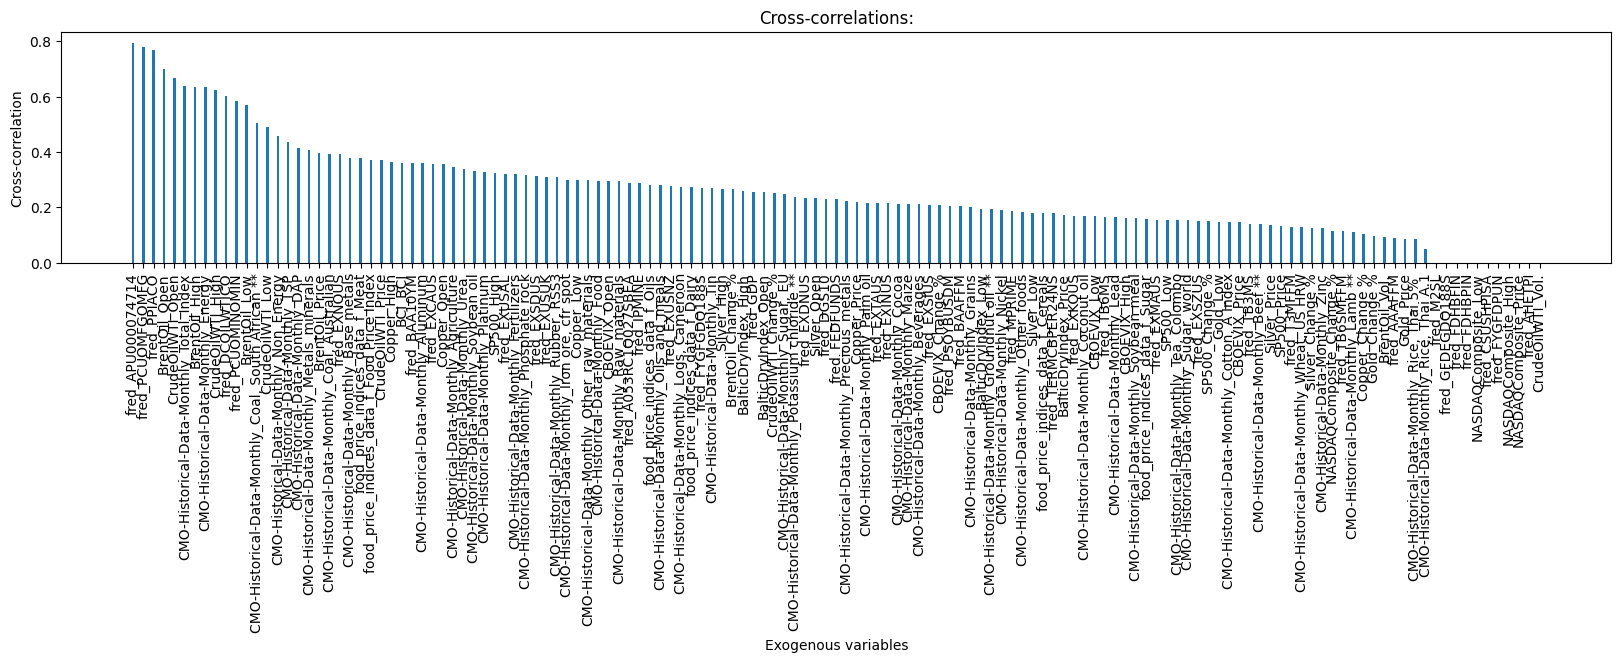

In [47]:
x,y=rank_best_features(unmodifiedDf,'fred_PCEPI')
display_ranked_ccf_variables(x,y)


In [ ]:
for col in unmodifiedDf.columns:
    
    stationary=is_stationary(unmodifiedDf[col])
    display_series(unmodifiedDf[col],decompose=(not stationary),title=col)
    mean,std=get_mean_std(unmodifiedDf[col])
    display(Markdown(f"**Stationary:** {stationary}   <br>**Mean:** {mean}<br>**Std:** {std}"))
    
